# UCI Heart Data Survival Model

Creating a model for UCI Heart Data




## Set up libraries and import data

In [ ]:
!pip install shap flask-ngrok

In [ ]:
import shap
import xgboost
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from flask import Flask, render_template, request, redirect, url_for, Response
from flask_ngrok import run_with_ngrok
from datetime import datetime
from io import StringIO
from werkzeug.wrappers import Response
import matplotlib.pylab as pl
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# read in data file
heart_data = pd.read_csv("/content/drive/My Drive/AI In Healthcare/heart_data_resampled.csv")

# turn data into data frame
heart_data_db = pd.DataFrame(heart_data)

##Exploratory Analysis

Find size and dimensions of the data set

In [ ]:
heart_data_db.shape

(10302, 15)

Number of predictors in the data set

In [ ]:
# Number of predictors in data set (not counting target column or numbering column)
print(len(heart_data_db.columns) - 2)

13


Take a look at the values in the data set

In [ ]:
heart_data_db

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63.000000,1.000000,3.000000,145.000000,233.000000,1.000000,0.000000,150.000000,0.000000,2.300000,0.000000,0.0,1.000000,1.0
1,1,37.000000,1.000000,2.000000,130.000000,250.000000,0.000000,1.000000,187.000000,0.000000,3.500000,0.000000,0.0,2.000000,1.0
2,2,41.000000,0.000000,1.000000,130.000000,204.000000,0.000000,0.000000,172.000000,0.000000,1.400000,2.000000,0.0,2.000000,1.0
3,3,56.000000,1.000000,1.000000,120.000000,236.000000,0.000000,1.000000,178.000000,0.000000,0.800000,2.000000,0.0,2.000000,1.0
4,4,57.000000,0.000000,0.000000,120.000000,354.000000,0.000000,1.000000,163.000000,1.000000,0.600000,2.000000,0.0,2.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,10297,56.494504,0.498901,1.002198,122.967023,268.995603,0.000000,0.000000,174.483511,0.000000,0.000000,2.000000,0.0,2.000000,1.0
10298,10298,54.192905,1.000000,1.403547,132.982264,195.508868,0.701774,0.298226,150.807095,0.000000,0.961419,0.298226,0.0,1.701774,1.0
10299,10299,55.058003,1.000000,2.000000,124.534298,255.732851,0.151143,0.151143,145.488567,0.151143,0.490686,1.000000,0.0,2.848857,1.0
10300,10300,51.485479,0.757261,2.000000,106.796700,220.543564,0.000000,0.757261,136.203300,0.757261,0.908713,1.242739,0.0,1.514521,1.0


Let's rename some of the variables to make them more readable and also get rid of the first column 

In [ ]:
heart_data_db = heart_data_db.rename(columns={"age": "Age", "sex": "Sex", "cp": "Chest Pain", "trestbps": "Resting BP", "restecg": "Resting ECG", "chol": "Serum Cholesterol", "fbs": "Fasting Blood Sugar > 120 mg/dl", "thalach": "Thalach", "thal": "Thal", "ca": "Number of major Blood Vessels", "exang": "Exercise Induced Angina", "oldpeak": "Exercise-induced ST depression", "slope": "Slope", "target": "Target" })
heart_data_db.drop(heart_data_db.columns[0], axis=1, inplace=True)
heart_data_db

,Age,Sex,Chest Pain,Resting BP,Serum Cholesterol,Fasting Blood Sugar > 120 mg/dl,Resting ECG,Thalach,Exercise Induced Angina,Exercise-induced ST depression,Slope,Number of major Blood Vessels,Thal,Target
0,63.000000,1.000000,3.000000,145.000000,233.000000,1.000000,0.000000,150.000000,0.000000,2.300000,0.000000,0.0,1.000000,1.0
1,37.000000,1.000000,2.000000,130.000000,250.000000,0.000000,1.000000,187.000000,0.000000,3.500000,0.000000,0.0,2.000000,1.0
2,41.000000,0.000000,1.000000,130.000000,204.000000,0.000000,0.000000,172.000000,0.000000,1.400000,2.000000,0.0,2.000000,1.0
3,56.000000,1.000000,1.000000,120.000000,236.000000,0.000000,1.000000,178.000000,0.000000,0.800000,2.000000,0.0,2.000000,1.0
4,57.000000,0.000000,0.000000,120.000000,354.000000,0.000000,1.000000,163.000000,1.000000,0.600000,2.000000,0.0,2.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,56.494504,0.498901,1.002198,122.967023,268.995603,0.000000,0.000000,174.483511,0.000000,0.000000,2.000000,0.0,2.000000,1.0
10298,54.192905,1.000000,1.403547,132.982264,195.508868,0.701774,0.298226,150.807095,0.000000,0.961419,0.298226,0.0,1.701774,1.0
10299,55.058003,1.000000,2.000000,124.534298,255.732851,0.151143,0.151143,145.488567,0.151143,0.490686,1.000000,0.0,2.848857,1.0
10300,51.485479,0.757261,2.000000,106.796700,220.543564,0.000000,0.757261,136.203300,0.757261,0.908713,1.242739,0.0,1.514521,1.0


Let's start by getting an idea of the distributions of our predictor and response variables. First we can see that our response variable, target, is binary meaning our model goal is to predict whether heart disease is present or not. We can see that most predictor variables are continuous and a few are binary as well. In some of the variables we can see clear bimodal distributions, which could help with distinguishing between our two outcomes.

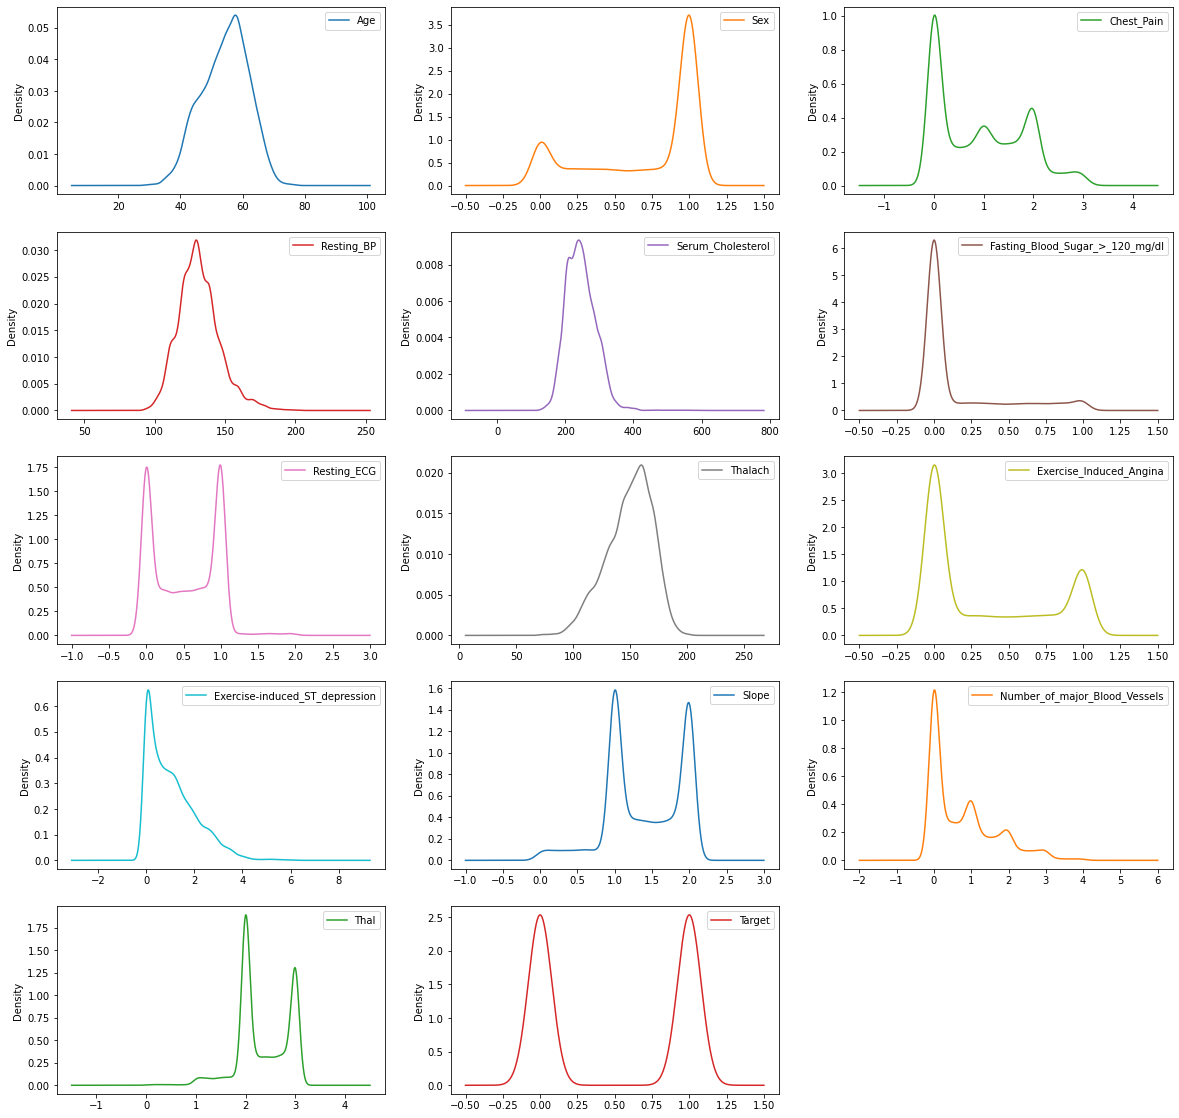

In [130]:
heart_data_db.plot(kind='density', subplots=True, layout=(5,3), figsize=(20,20), sharex=False)
pl.show()

Now let's take a look at the correlation between our variables and see if there are any distinct relationships that can help us determine what model we should use. There is a particularly close relationship between the Exercise Induced Angina and Exercise-induced ST depression variables which we can look into. In terms of predictor relationships with the response variable, Exercise Induced Angina, Exercise-induced ST depression, Number of major Blood Vessels > 120 mg/dl, and Thal have the strongest negative correlation, while Chest Pain, thalach and slope have the strongest positive correlation. 

Correlation Matrix
- Finds correlations between variables to find most impactful set of values

,Age,Sex,Chest Pain,Resting BP,Serum Cholesterol,Fasting Blood Sugar > 120 mg/dl,Resting ECG,Thalach,Exercise Induced Angina,Exercise-induced ST depression,Slope,Number of major Blood Vessels,Thal,Target
Age,1.000000,-0.061057,-0.091234,0.300674,0.227477,0.115621,-0.153484,-0.417015,0.132511,0.265120,-0.213646,0.323827,0.111881,-0.290115
Sex,-0.061057,1.000000,-0.117550,-0.082024,-0.185393,0.026311,-0.057023,-0.099737,0.185493,0.156386,-0.074315,0.161209,0.253203,-0.339179
Chest Pain,-0.091234,-0.117550,1.000000,0.027100,-0.096639,0.072023,0.069917,0.339703,-0.452838,-0.225150,0.177317,-0.242189,-0.237984,0.499288
Resting BP,0.300674,-0.082024,0.027100,1.000000,0.153625,0.163300,-0.132670,-0.076562,0.069479,0.184550,-0.130646,0.113428,0.056646,-0.154071
Serum Cholesterol,0.227477,-0.185393,-0.096639,0.153625,1.000000,0.027524,-0.164466,-0.060388,0.092907,0.040321,0.003166,0.109870,0.096217,-0.114896
Fasting Blood Sugar > 120 mg/dl,0.115621,0.026311,0.072023,0.163300,0.027524,1.000000,-0.104057,-0.008334,0.047955,-0.002585,-0.057326,0.156447,-0.067737,-0.036593
Resting ECG,-0.153484,-0.057023,0.069917,-0.132670,-0.164466,-0.104057,1.000000,0.067369,-0.093207,-0.075477,0.112011,-0.107193,-0.049292,0.168959
Thalach,-0.417015,-0.099737,0.339703,-0.076562,-0.060388,-0.008334,0.067369,1.000000,-0.442292,-0.415557,0.454558,-0.272008,-0.159472,0.482556
Exercise Induced Angina,0.132511,0.185493,-0.452838,0.069479,0.092907,0.047955,-0.093207,-0.442292,1.000000,0.353107,-0.320355,0.190510,0.254091,-0.494982
Exercise-induced ST depression,0.265120,0.156386,-0.225150,0.184550,0.040321,-0.002585,-0.075477,-0.415557,0.353107,1.000000,-0.603682,0.291642,0.257910,-0.508860


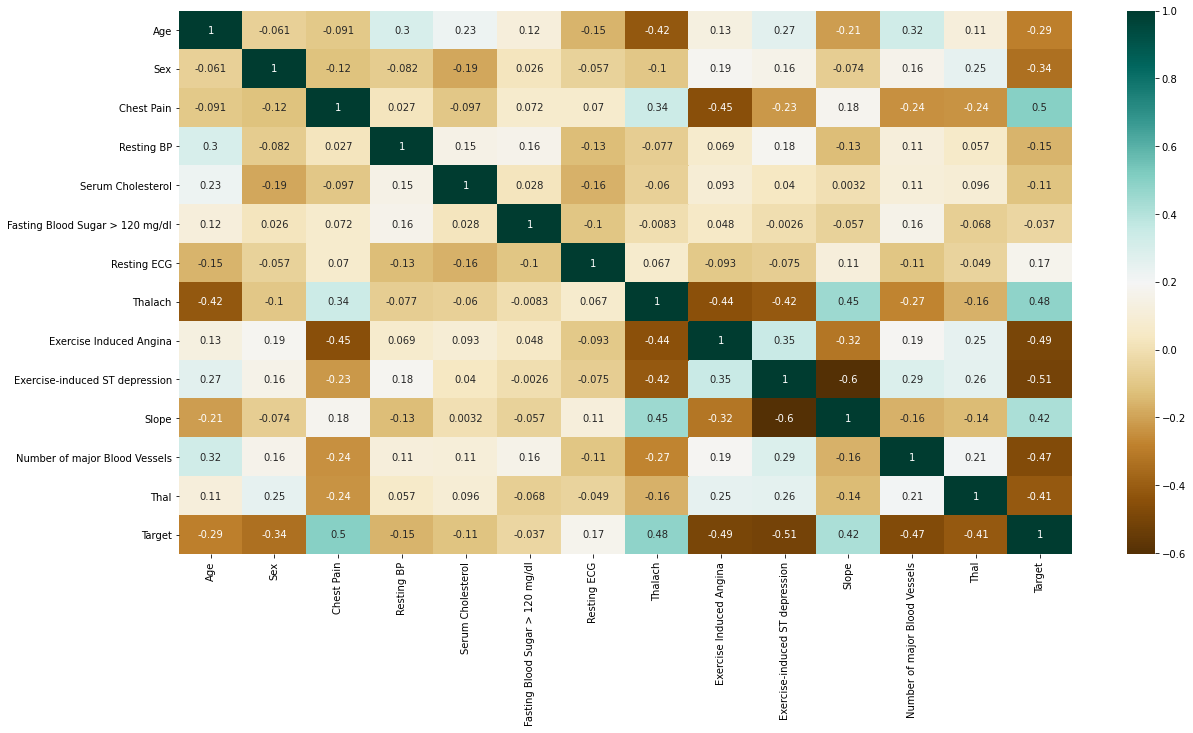

In [ ]:
pl.figure(figsize=(20,10));
c= heart_data_db.corr();
sns.heatmap(c,cmap="BrBG",annot=True)
c

Let's take a look at the most correlated variables, slope and Exercise-induced_ST_depression. If we take a look at the description of each variable, it makes sense that they are correlated because they both are measurements from an exercise test, one measuring the peak of a depression and the other measuring the slope. Observations with a high peak are likely to have a steep slope. In the graph we can see a pretty strong negative relationship between the variables, but it is quite noisy.

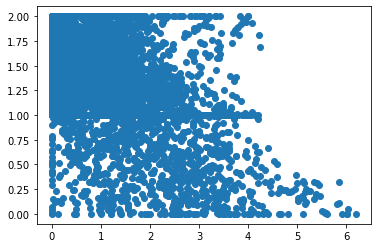

In [ ]:
oldpeak  = heart_data_db["Exercise-induced_ST_depression"]
slope = heart_data_db["Slope"]


pl.scatter( oldpeak, slope,label = "Exercise Induced Angina")

Now lets take a look at the positively correlated variables and how well it maps to the binary outcome variable. Looking at the boxplots of each variable seperated based on the outcome, we can see that each subset is pretty distinguishable from the other within the interquartile range, but there is definite overlap with outliers and tails. This indicates that there is a relationship, but a simple logistic regression model would struggle to seperate the observations into the correct response and would be a poor model choice. So we would need a more complicated model, such as XGBoost to capture the relationships.  

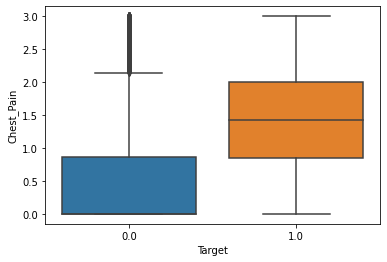

In [ ]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Chest_Pain')

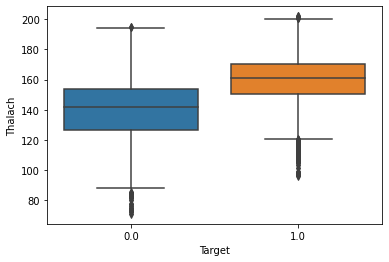

In [ ]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Thalach')

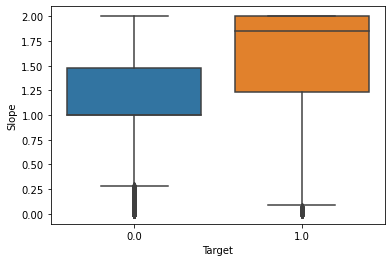

In [ ]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Slope')

Now looking at the negatively correlated variables we see something similar. Again the interquartile range of the subsets is pretty dicernable, but there are a lot of outliers outside of that which overlap with each other, especially for the target= 1 subset. This noisy relationship again indicates the need for a more complicated model to properly capture it rather than a simple logistic regression model.

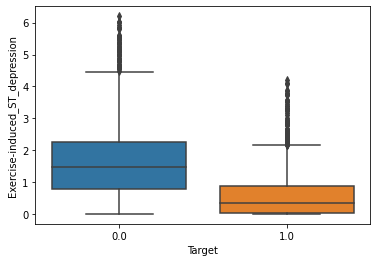

In [ ]:
sns.boxplot(data = heart_data_db, x = 'Target', y = "Exercise-induced_ST_depression")


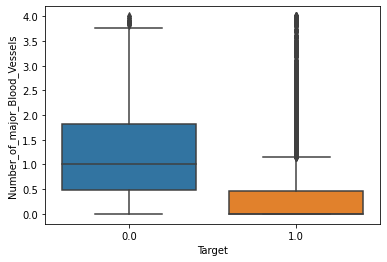

In [ ]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Number_of_major_Blood_Vessels')

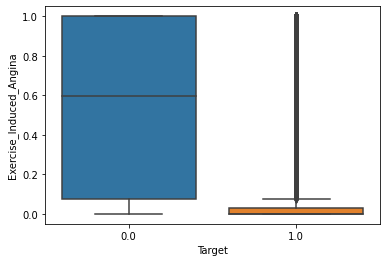

In [ ]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Exercise_Induced_Angina')

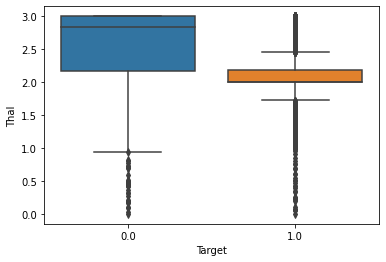

In [ ]:
sns.boxplot(data = heart_data_db, x = 'Target', y = "Thal")

## Create XGBoost data objects

This uses a pre-processed subset of Heart Disease data available from UCI. We split the dataframe into the predictors and the labels, and then create an 80/20 train/test split.


In [182]:
heart_data_db.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
# Load the dataframe into subsets for data and labels
X = heart_data_db.loc[:,'Age':'Thal']
y = heart_data_db.loc[:,'Target'].to_numpy();

In [183]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

## Train XGBoost model

Here, we are using a custom function that fits the XGB Classifier to our model and also cross validates it each boosting round (using 5-fold CV). The function was adapted from Aarshay Jain's blog post: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [184]:
def modelfit(alg, dtrain, labels, test, testlabels, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(X_train, y_train)
        cvresult = xgboost.cv(xgb_param, xgtrain, verbose_eval=1000, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, labels,eval_metric='logloss')
        
    #Predict training set:
    preds = alg.predict(test)
    test_pred = []
    for val in preds:
      if val >= 0.5:
          test_pred.append(1)
      else :
          test_pred.append(0)

    #Print model report:
    print("\nModel Report")
    cf_matrix = confusion_matrix(testlabels, test_pred)
    report = classification_report(testlabels, test_pred)
    print ("Confusion Matrix")
    print(cf_matrix)
    print(report)
    return alg

In [185]:
from xgboost import plot_tree
from xgboost import XGBClassifier
from xgboost import cv

xgb2 = XGBClassifier(
 learning_rate =0.002,
 n_estimators=20000,
 max_depth=3,
 verbose_eval=1000,
 eval_metric='logloss',
 min_child_weight=6,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 early_stopping_rounds=10,
 seed=7);
#xgb2.fit(X_train, y_train)
modelfit(xgb2, X_train, y_train, X_test, y_test)

[0]	train-logloss:0.691941+1.04307e-05	test-logloss:0.691966+1.29151e-05
[1000]	train-logloss:0.260466+0.00168727	test-logloss:0.267878+0.00462552
[2000]	train-logloss:0.174351+0.00192732	test-logloss:0.18574+0.00597319
[3000]	train-logloss:0.139948+0.0018343	test-logloss:0.154551+0.0066359
[4000]	train-logloss:0.120425+0.00173273	test-logloss:0.137653+0.00676939
[5000]	train-logloss:0.106459+0.00151252	test-logloss:0.125858+0.00665833
[6000]	train-logloss:0.0954962+0.00134046	test-logloss:0.116618+0.00652291
[7000]	train-logloss:0.0864066+0.00123998	test-logloss:0.109094+0.00629143
[8000]	train-logloss:0.0787594+0.0011149	test-logloss:0.10278+0.00628411
[9000]	train-logloss:0.0721984+0.00106168	test-logloss:0.0974362+0.00618622
[10000]	train-logloss:0.0663872+0.00100404	test-logloss:0.0926834+0.00615639
[11000]	train-logloss:0.061234+0.000935019	test-logloss:0.0884736+0.00609945
[12000]	train-logloss:0.0566918+0.000946291	test-logloss:0.0848132+0.00589941
[13000]	train-logloss:0.05266

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eval_metric='logloss', gamma=0,
              learning_rate=0.002, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=None, n_estimators=20000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7,
              silent=None, subsample=0.5, verbose_eval=1000, verbosity=1)

Here is an example of one of the trees generated in the XGBoost ensemble

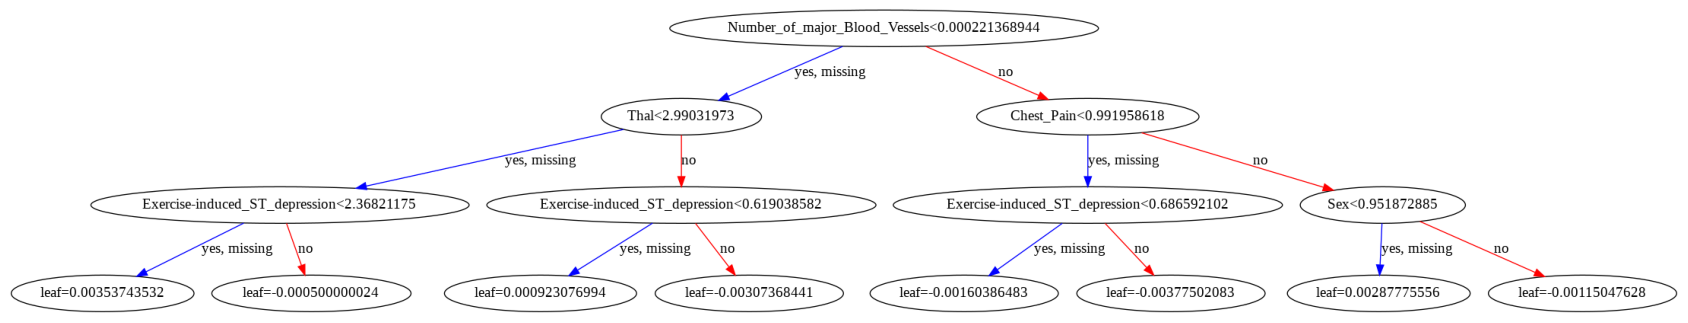

In [186]:
fig, ax = pl.subplots(figsize=(30, 30))
plot_tree(xgb2,num_trees=0, ax=ax)
pl.show()

## Explain the model's predictions by using SHAP

---



In [187]:
# compute SHAP values 
shap_values = shap.TreeExplainer(xgb2).shap_values(X) 
explainer = shap.Explainer(xgb2, X)
shap_values_bar = explainer(X)

100%|===================| 10299/10302 [62:19<00:01]       

### SHAP Summary Plot

The summary plot and bar plots evaluate the effects of individual features (or predictors) on the models outcome, and it ranks which features matter the most for determining heart disease.

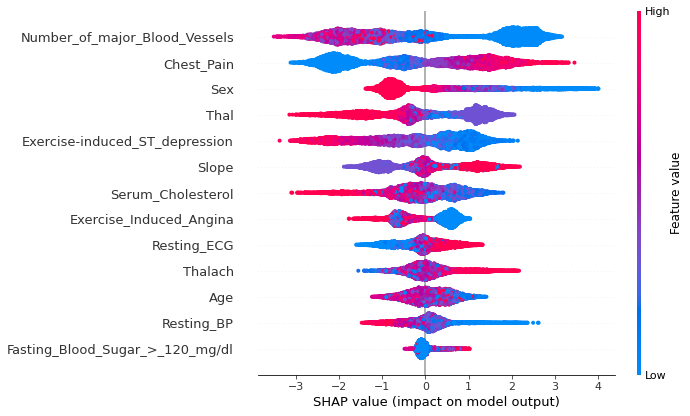

In [188]:
shap.summary_plot(shap_values, X)

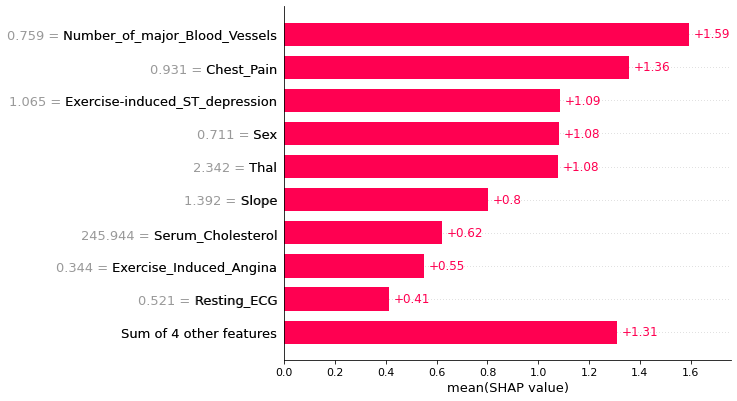

In [189]:
shap.plots.bar(shap_values_bar)

## Compute SHAP Interaction Values

The interaction summary plot identifies the relations between variables, similar to the correlation plot from earlier, but with the model used as a baseline.

In [192]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(xgb2).shap_interaction_values(X.iloc[:,:])

### SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

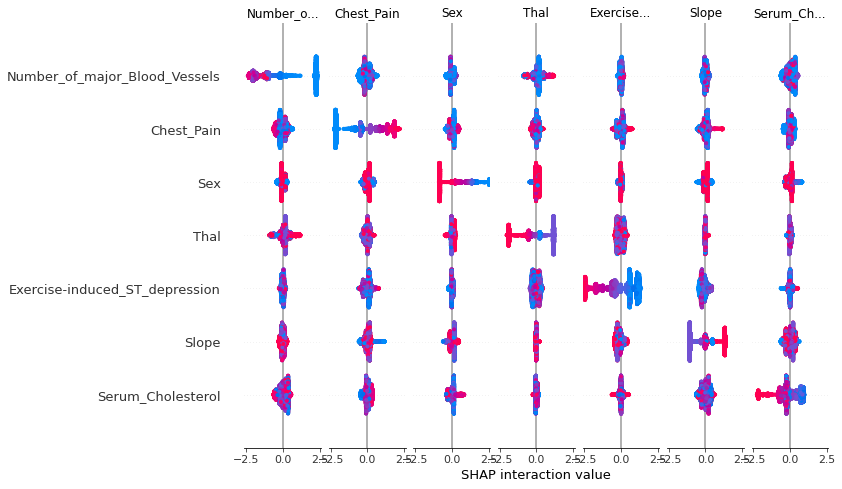

In [195]:
shap.summary_plot(shap_interaction_values, X.iloc[:,:])

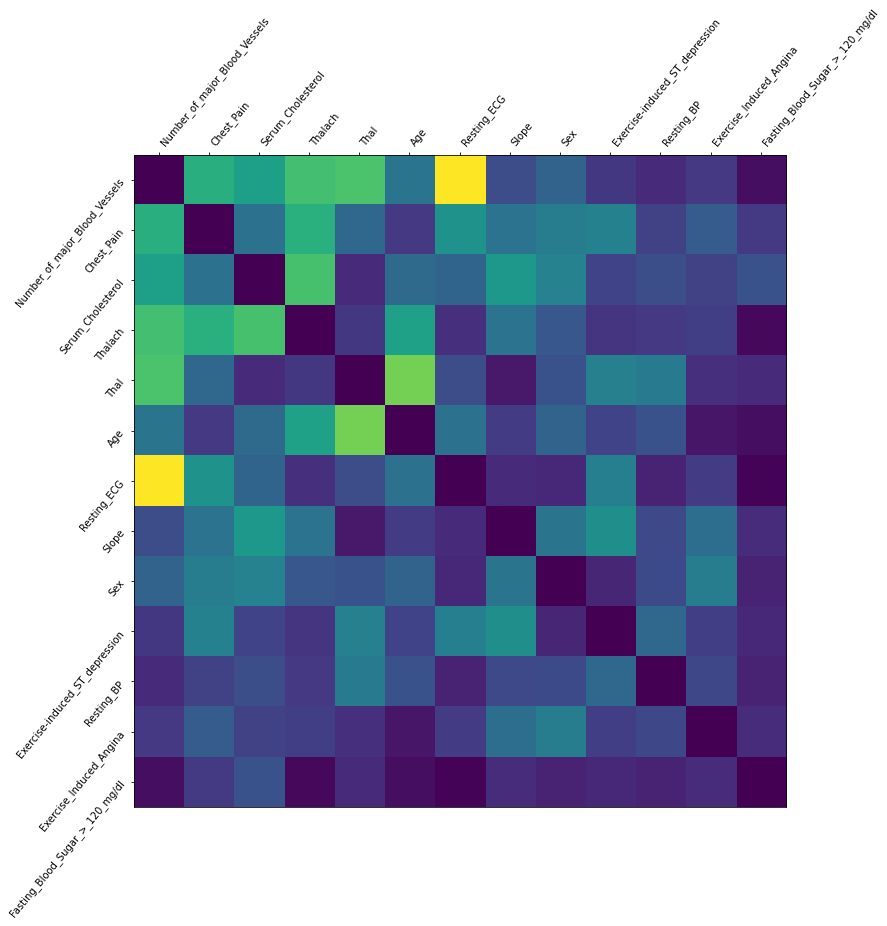

In [196]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

## Using Model to Predict Test Values

Run on test set to evaluate model performance. We call the predict_proba function to generate an array of probablities for heart disease for each datapoint in the testing set.

In [197]:
preds = xgb2.predict_proba(X_test)
preds = np.delete(preds, 0, 1)

Convert Percentages into bianary classification

In [198]:
test_pred = []
for val in preds[:,]:
  if val >= 0.5:
      test_pred.append(1)
  else :
      test_pred.append(0)

Create Confusion Matrix and display (again). Here is a graphic describing the confusion matrix and the relevant metrics. We will use those metrics to evaluate our model. Image taken from: https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html

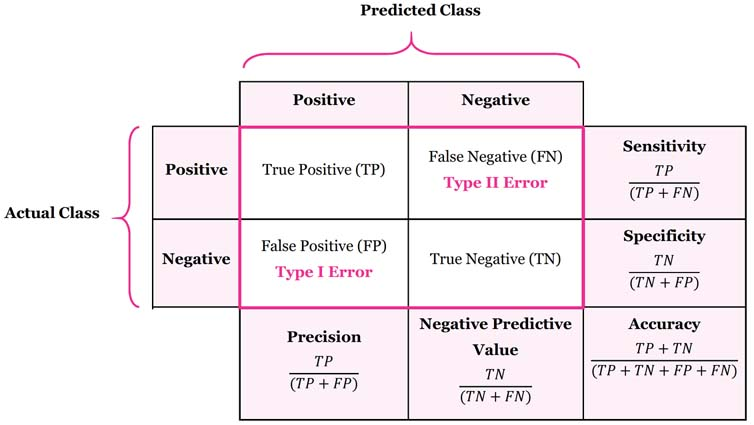

In [199]:
# create confusion matrix. This is the same as the one printed by the modelfit function.
cf_matrix = confusion_matrix(y_test, test_pred)
report = classification_report(y_test, test_pred)
print ("Confusion Matrix")
print(cf_matrix)
print(report)
tp = cf_matrix[0][0]
fp = cf_matrix[0][1]
fn = cf_matrix[1][0]
tn = cf_matrix[1][1]

Confusion Matrix
[[1018   13]
 [  22 1008]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1031
         1.0       0.99      0.98      0.98      1030

    accuracy                           0.98      2061
   macro avg       0.98      0.98      0.98      2061
weighted avg       0.98      0.98      0.98      2061



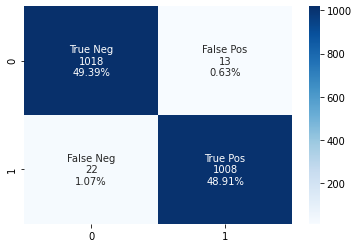

In [200]:
# display results
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_labels = ["{}\n".format(value) for value in group_names]
group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
labels = np.asarray(box_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

**Find Performance Metrics**

Accuracy
- percentage of values predicted correctly

In [201]:
(tp + tn) / (tp + fp + fn + tn)


0.9830179524502669

Recall/Sensitivity
- percentage of positive values predicted correctly

In [202]:
tp / (tp + fn)

0.9788461538461538

Precision
- percentage of values that were predicted as positive that were actually postive

In [203]:
tp / (tp + fp)


0.9873908826382153

Specificity
- percentage of negative values that were predicted correctly

In [204]:
tn / (tn + fp)

0.9872673849167483

Negative Predictive Value
- of the values that were predicted as negative, what percentage were actually negative

In [205]:
tn / (tn + fn)

0.9786407766990292

**Area Under the Receiver Operating Characteristics curve (AU-ROC)**


*  Measures how good the model is at distinguishing between classes 



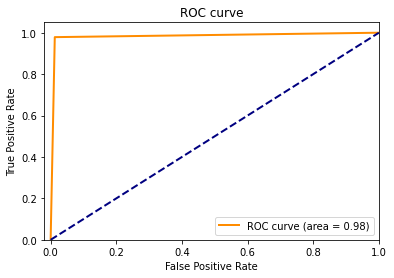

In [206]:
    fpr, tpr, _ = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    pl.figure()
    lw = 2
    pl.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    pl.xlim([-0.02, 1.0])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('ROC curve')
    pl.legend(loc="lower right")
    pl.show()

## Creating a Web Calculator
Use our model to predict the likelihood of heart disease based on inputted 
predictors

Here is what the web app looks like:

In [138]:
import IPython
IPython.display.HTML("/content/drive/My Drive/AI In Healthcare/index.html")

In [151]:
# Run this cell and open the second link to access the rendered webapp. 
app = Flask(__name__, template_folder='drive/My Drive/AI In Healthcare')
run_with_ngrok(app)

@app.route('/')
def home():
  return render_template("index.html")

@app.route('/submit', methods=['GET', 'POST'])
def submit():

  if request.method == 'POST':
    req = request.form.to_dict()
    for key in req:
        req[key] = float(req[key])
    df = pd.DataFrame([req.values()], columns=req.keys())
    result = str("{:.2f}".format(xgb2.predict_proba(df)[:,1][0] * 100) + '%')
    return render_template("index.html", result=result)
  return render_template("index.html")

if __name__ =='__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://20d77f177887.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [28/Sep/2020 00:18:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Sep/2020 00:18:47] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [28/Sep/2020 00:18:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Sep/2020 00:19:21] "POST /submit HTTP/1.1" 200 -
